### Résolution d'une équation complexe

On s’intéresse à la recherche des solutions complexes de l’équation $z^3 = 1$. Pour cela nous allons utiliser la méthode de Newton appliquée à la fonction vectorielle de 2 variables
$F : (x,y)->(Re((x+i y)^3-1),Im((x+i y)^3-1))$, fonction qui s'annule exactement lorsque $(x+i y)^3=1$.
On donne ci-dessous le code Python définissant cette fonction (que l'on compile via jit).
Définir une fonction DF qui retourne la différentielle de la F (sa matrice Jacobienne).

In [8]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from numba import jit, float64

@jit('float64[:](float64, float64)',nopython=True)
def F(x,y):
    return np.array([-1.+x**3-3.*x*y**2, 3.*x**2*y-y**3])


#Optimisation
@jit('float64[:,:](float64, float64)',nopython=True)
def DF(x,y):
    return np.array([[-3.*y**2 + 3.*x**2, -6.*x*y], [6.*x*y, 3.*x**2 - 3.*y**2]])

*Justifier cette implémentation*
Cette fonction résulte du développement de la fonction $(x + iy)^3 -1$ où l'on retrouve bien comme partie réelle $-1 + x^3 - 3*x*y^2$ et comme partie imaginaire $3*y*x^2 - y^3$.


Calculer les solutions de l'équation $z^3 = 1$ et vérifier en Python que la fonction vectorielle précédemment définie s'annule bien pour ces 3 valeurs

In [9]:
z=np.empty(3, dtype='complex')
z[0] = np.exp(2j*np.pi/3)
z[1] = np.exp(4j*np.pi/3)
z[2] = 1

for i in range(3):
    x = np.real(z[i])
    y = np.imag(z[i])
    print(np.allclose(F(x,y),0))


True
True
True


Définir une fonction Newton, qui pour une initialisation donnée et une tolérance fixée calcule et retourne les valeurs des parties réelle et imaginaire de la solution de l'équation $z^3 = 1$. On retournera également le nombre d'itérations pour atteindre la tolérance (que l'on limitera à 100).

Converge vers : 1.0 0.0


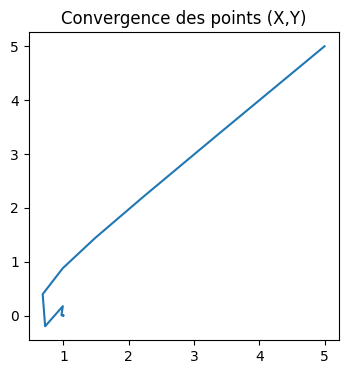

Point de convergence : (1+0j)
Racine calculée analytiquement : (1+0j)
Égales ?  True


In [11]:
#@jit('Tuple((float64[:], float64[:], int))(float64[:], float64, int)',nopython=True)
def newton2d(F, DF, X0, tol, max_iter):
    tol = 1e-15
    [x,y] = X0
    X = [x]
    Y = [y]
    it = 0
    erreur = tol+1
    while it < max_iter and erreur > tol :
        #Mémoire des anciennes valeurs
        x_1 = x
        y_1 = y

        #Calcul iteration suivante
        [x,y] = [x,y] - (la.solve(DF(x,y), F(x,y)))
        X.append(x)
        Y.append(y)
        it += 1

        #Calcul erreur
        erreur = la.norm(np.array(x,y) - np.array(x_1,y_1))
    return X, Y, it


# Initialisation
X0 = 5*np.ones(2)
#X0[1] = -10
tol = 1e-15
max_iter = 20

# Calcul
X, Y, nb_iter = newton2d(F, DF, X0, tol, max_iter)
print('Converge vers :', X[-1],Y[-1])

# Tracé graphique
X = np.array(X)
Y = np.array(Y)
plt.figure(figsize=(4,4))
plt.plot(X,Y)
plt.title('Convergence des points (X,Y)')
plt.show()

x=X[-1]
y=Y[-1]
racine = [np.exp(i*2j*np.pi/3) for i in range(3)]

print('Point de convergence :', x + y*1j)
print('Racine calculée analytiquement :', racine[0])
print('Égales ? ', np.allclose(x+1j*y, racine[0], atol=1e-5))


On choisit maintenant l'initialisation dans une grille couvrant le carré $[−1.5, 1.5] \times [−1.5, 1.5]$ de pas $h = 3/n$, $n$ étant un entier.
En choisissant comme initialisation chaque point de la grille $(x_i , y_j )$, on résoud alors $F(x, y) = 0$ par la méthode de Newton et dans un premier tableau, on mémorisera le numéro $k$ entre 1 et 3 de la racine $exp(2ik\pi/3)$ vers lequel l’algorithme aura convergé. Dans un deuxième tableau, on mémorisera le nombre d'itération pour converger.

À partir des résultats précédents construire une image de taille $n \times n$. Chaque point de cette image prend une couleur différente en fonction de la racine vers laquelle l'algorithme a convergé. La teinte de cette couleur sera pondérée par le nombre d'itérations nécessaires pour converger (le codage de couleurs HSV est adapté à la description précédente, il faudra ensuite la convertir en RGB pour créer l'image).

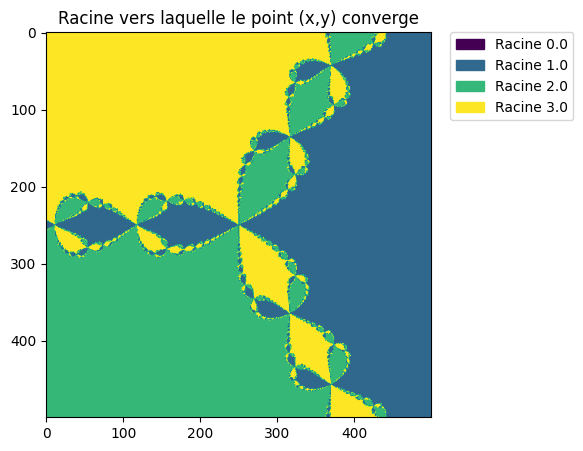

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps

tol = 1e-15
max_iter = 100
n = 500
h = 3/n
X = np.arange(-1.5, 1.5, h)
Y = np.arange(-1.5, 1.5, h)

K = np.zeros((len(X),len(Y)))
#K = np.zeros((len(X),len(Y),3))
Iter = np.zeros((len(X),len(Y)))
racines = [np.exp(i*2j*np.pi/3) for i in range(3)]

for i in range(len(X)):
    for j in range(len(Y)):
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2d(F, DF, x0, tol, max_iter)
        z = Xnewt[-1] + 1j*Ynewt[-1]

        if np.allclose(z, racines[0], atol=1e-2) :
            K[j,i] = 1
            #K[j,i] = (0, 0, 255)
        elif np.allclose(z, racines[1], atol=1e-2):
            K[j,i] = 2
            #K[j,i] = (255, 0, 0)
        elif np.allclose(z, racines[2], atol=1e-2) :
            K[j,i] = 3
            #K[j,i] = (0, 255, 0)


### Affichage 
fig, ax = plt.subplots(figsize=(5,5))
im = plt.imshow(K) #, cmap = 'winter')

### Tracé de la légende ###
values = np.unique(K.ravel())
# get the colors of the values, according to the colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=colors[i], label="Racine {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.title('Racine vers laquelle le point (x,y) converge')
plt.show()

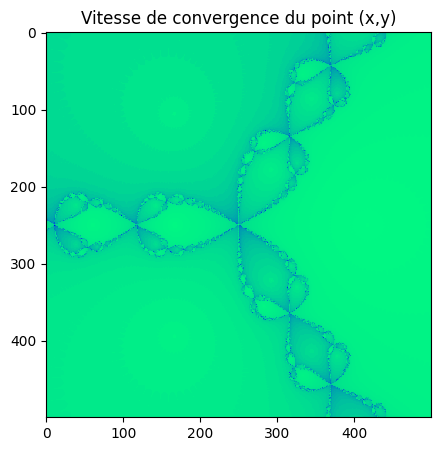

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps
from matplotlib.colors import hsv_to_rgb


tol = 1e-15
max_iter = 50
n = 500
h = 3/n
X = np.arange(-1.5, 1.5, h)
Y = np.arange(-1.5, 1.5, h)
eps = 1e-5

K = np.zeros((len(X),len(Y)))
Iter = np.zeros((len(X),len(Y)))
racines = [np.exp(i*2j*np.pi/3) for i in range(3)]

for i in range(len(X)):
    for j in range(len(Y)):

        #Calcul solution
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2d(F, DF, x0, tol, max_iter)
        z = Xnewt[-1] + 1j*Ynewt[-1]

        #Classification des points de convergences
        if np.allclose(z, racines[0], atol=1e-2) :
            K[j,i] = 1 * (1-it)/162                     #162 est le nombre maximal d'itérations avant convergence
        elif np.allclose(z, racines[1], atol=1e-2):
            K[j,i] = 2 * (1-it)/162
        elif np.allclose(z, racines[2], atol=1e-2) :
            K[j,i] = 3 * (1-it)/162

#Tracé figure
fig, ax = plt.subplots(figsize=(5,5))
im = plt.imshow(K, interpolation='none', cmap='winter')
plt.title('Vitesse de convergence du point (x,y)')
plt.show()

#Plus le point est clair, moins il converge vite.

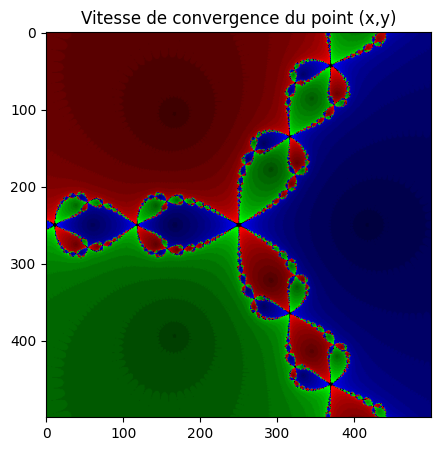

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps


tol = 1e-15
max_iter = 20
n = 500
h = 3/n
X = np.arange(-1.5, 1.5, h)
Y = np.arange(-1.5, 1.5, h)

K = np.zeros((len(X),len(Y), 3))
Iter = np.zeros((len(X),len(Y)))
racines = [np.exp(i*2j*np.pi/3) for i in range(3)]

for i in range(len(X)):
    for j in range(len(Y)):

        #Calcul solution
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2d(x0, tol, max_iter)
        z = Xnewt[-1] + 1j*Ynewt[-1]

        #Classification des points de convergences
        if np.allclose(z, racines[0], atol=1e-2) :
            #K[j,i] = 1 * (1-it)/162        #162 est le nombre maximal d'itérations avant convergence
            K[j,i] = (0, 0, 255 * (it)/max_iter)
        elif np.allclose(z, racines[1], atol=1e-2):
            #K[j,i] = 2 * (1-it)/162
            K[j,i] = (0, 255 * (it)/max_iter, 0)
        elif np.allclose(z, racines[2], atol=1e-2) :
            #K[j,i] = 3 * (1-it)/162
            K[j,i] = (255 * (it)/max_iter, 0, 0)



#Tracé figure
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(K.astype('uint8'))
plt.title('Vitesse de convergence du point (x,y)')
plt.show()

#Plus le point est clair, moins il converge vite.

Constuire une nouvelle image, mais cette fois sur le domaine de taille  $ 0.2 \times 0.2$ centré en $[0.5,0.5]$. Que peut-on conjecturer sur la nature de cette représentation graphique ?

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

tol = 1e-15
max_iter = 500
n = 10000
h = 3/n
X = np.arange(0.4, 0.6, h)
Y = np.arange(0.4, 0.6, h)

K = np.zeros((len(X),len(Y)))
Iter = np.zeros((len(X),len(Y)))

for i in range(len(X)):
    for j in range(len(Y)):
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2d(x0, tol, max_iter)

        z = Xnewt[-1] + 1j*Ynewt[-1]
        racine = [np.exp(i*2j*np.pi/3) for i in range(3)]

        if np.allclose(z, racine[0], atol=1e-2) :
            K[i,j] = 1
        elif np.allclose(z, racine[1], atol=1e-2):
            K[i,j] = 2
        elif np.allclose(z, racine[2], atol=1e-2) :
            K[i,j] = 3

        Iter[i,j] = it


fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(K)

###Tracé de la légende###
im = plt.imshow(K, interpolation='none')
values = np.unique(K.ravel())
# get the colors of the values, according to the colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=colors[i], label="Racine {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.title('Racine vers laquelle le point (x,y) converge')
plt.show()

Reprendre la méthode précédente et construire l'image associée à la recherche des zéros du polynome $p(z) = z^3 - 2z + 2$. On ajoutera une couleur pour les points ou l'algorithme de Newton ne converge pas.*

*On peut aussi s'intéresser à $p(z) = z^5-1$.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps
from numba import jit, float64

@jit('float64[:](float64, float64)',nopython=True)
def G(x,y):
    return np.array([x**3-3.*x*y**2-2*x+2, 3.*x**2*y-y**3-2*y])

@jit('float64[:,:](float64, float64)',nopython=True)
def DG(x,y):
    return np.array([[-3.*y**2 + 3.*x**2 -2, -6.*x*y], [6.*x*y, 3.*x**2 - 3.*y**2 -2]])

def newton2dG(X0, tol, max_iter):
    tol = 1e-15
    [x,y] = X0
    X = [x]
    Y = [y]
    iter = 0
    erreur = tol+1
    while iter < max_iter and erreur > tol :
        #Mémoire des anciennes valeurs
        x_1 = x
        y_1 = y

        #Calcul solution
        [x,y] = [x,y] - (la.solve(DG(x,y), G(x,y)))
        X.append(x)
        Y.append(y)
        iter += 1

        #Calcul erreur
        erreur = la.norm(np.array(x,y) - np.array(x_1,y-1))
    return X, Y, iter


#Initialisation
tol = 1e-15
max_iter = 20
n = 500
h = 3/n
X = np.arange(-1.5, 1.5, h)
Y = np.arange(-1.5, 1.5, h)

K = np.zeros((len(X),len(Y), 3))
Iter = np.zeros((len(X),len(Y)))

racinesG = [-1.76929 + 0j, 0.88464 - 0.58974j, 0.88464 + 0.58974j]

for i in range(len(X)):
    for j in range(len(Y)):
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2dG(x0, tol, max_iter)

        z = Xnewt[-1] + 1j*Ynewt[-1]
        racine = [np.exp(i*2j*np.pi/3) for i in range(3)]

        if np.allclose(z, racinesG[0], atol=1e-1) :
            #K[j,i] = 1
            K[j,i] = (0, 0, 255 * (it)/max_iter)
        elif np.allclose(z, racinesG[1], atol=1e-1):
            #K[j,i] = 2
            K[j,i] = (255 * (it)/max_iter, 0, 0)
        elif np.allclose(z, racinesG[2], atol=1e-1) :
            #K[j,i] = 3
            K[j,i] = (0, 255 * (it)/max_iter, 0)

        Iter[j,i] = it


fig, ax = plt.subplots(figsize=(5,5))
im = plt.imshow(K.astype('uint8'), interpolation='none')
plt.title('Points non convergeants en noir')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps


tol = 1e-15
max_iter = 100
n = 300
h = 3/n
X = np.arange(-1.5, 1.5, h)
Y = np.arange(-1.5, 1.5, h)

K = np.zeros((len(X),len(Y)))
Iter = np.zeros((len(X),len(Y)))

for i in range(len(X)):
    for j in range(len(Y)):

        #Calcul solution
        x0 = [X[i],Y[j]]
        Xnewt, Ynewt, it = newton2dG(x0, tol, max_iter)

        #Dernière valeur a convergé
        z = Xnewt[-1] + 1j*Ynewt[-1]

        #Classification des points de convergences
        if np.allclose(z, racinesG[0], atol=1e-2) :
            K[j,i] = 1 * (1-it)/162
            #K[j,i] *= (1-it)/162                     #162 est le nombre maximal d'itérations avant convergence
        elif np.allclose(z, racinesG[1], atol=1e-2):
            K[j,i] = 2 * (1-it)/162
            #K[j,i] *= (1-it)/162
        elif np.allclose(z, racinesG[2], atol=1e-2) :
            K[j,i] = 3 * (1-it)/162
            #K[j,i] *= (1-it)/162

        Iter[j,i] = it


#Tracé figure
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(K, cmap = 'viridis')

###Tracé de la légende###
im = plt.imshow(K, interpolation='none')
values = np.unique(K.ravel())
# get the colors of the values, according to the colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=colors[i], label="Racine {l}".format(l=values[i])) for i in range(len(values))]
# put those patched as legend-handles into the legend
#plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.title('Vitesse de convergence du point (x,y)')
plt.show()

#Plus le point est clair, moins il converge vite.

TD MPSI

Fractales méthodes mat faire champ de vecteur qui convergent vers les racines :  a chaque point du plan, on lui associe le premier vecteur de convergence de l'algo.
Coder ensemble Mandelbrot ou Junia


100%|██████████| 800/800 [01:13<00:00, 10.85it/s]


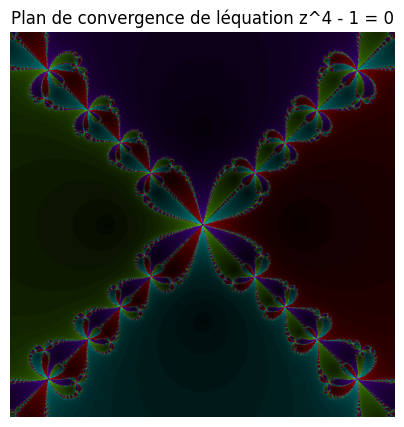

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from tqdm import trange, tqdm


def newton_fractal(width, height, x_min, x_max, y_min, y_max, max_iter=50, epsilon=1e-6):
    image = np.zeros((height, width, 3))
    roots = [1, -1, 1j, -1j]  # Roots of z^4 - 1 = 0

    for y in tqdm(range(height)):
        for x in range(width):
            zx = x_min + (x / width) * (x_max - x_min)
            zy = y_min + (y / height) * (y_max - y_min)
            z = complex(zx, zy)

            for i in range(max_iter):
                dz = 4 * z**3  # Derivative of z^4 - 1 = 0
                z = z - (z**4 - 1) / dz if dz != 0 else 0
                if abs(z**4 - 1) < epsilon:
                    break

            # Color mapping based on which root the point converged to
            for j, root in enumerate(roots):
                if abs(z - root) < epsilon:
                    hue = j / len(roots)
                    saturation = 1
                    value = i / max_iter
                    image[y, x] = hsv_to_rgb([hue, saturation, value])
                    break

    return image



width = 800
height = 800
x_min, x_max = -2, 2
y_min, y_max = -2, 2
max_iter = 50
epsilon = 1e-6

fractal_image = newton_fractal(width, height, x_min, x_max, y_min, y_max, max_iter, epsilon)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(fractal_image)
plt.title('Plan de convergence de l équation z^4 - 1 = 0')
plt.axis('off')
plt.show()



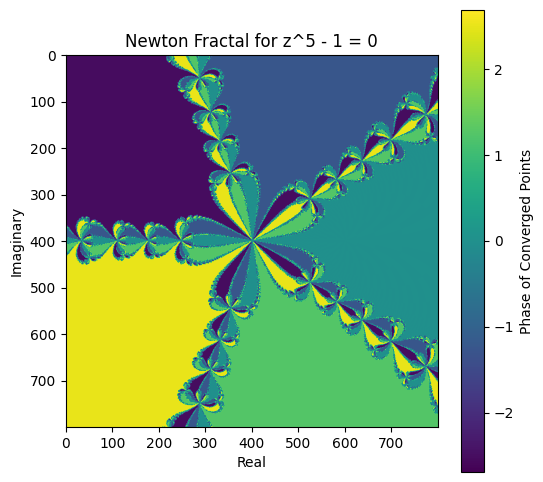

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function and its derivative
def f(z):
    return z**5 - 1

def f_prime(z):
    return 5*z**4

# Define Newton's method
def newton(z, tol=1e-3, max_iter=100):
    for _ in range(max_iter):
        dz = f(z) / f_prime(z)
        z -= dz
        if abs(dz) < tol:
            return z
    return z

# Define the region in the complex plane to explore
x_min, x_max = -2, 2
y_min, y_max = -2, 2
resolution = 800

# Generate the grid of complex numbers
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Apply Newton's method to each point in the grid
converged_points = np.zeros(Z.shape, dtype=complex)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        converged_points[i, j] = newton(Z[i, j])

# Plot the result
plt.figure(figsize=(6, 6))
plt.imshow(np.angle(converged_points), cmap='viridis', extent=(x_min, x_max, y_min, y_max))
plt.title("Newton Fractal for z^5 - 1 = 0")
plt.colorbar(label='Phase of Converged Points')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()
